In [3]:
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

sns.set_theme(style="white")
%load_ext autoreload
%autoreload 2

UsageError: Line magic function `%` not found.


## Define GP Model

In [61]:
class EEGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel: str = "matern",
                 lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
                 outputscale_prior=gpytorch.priors.GammaPrior(2.0, 0.15)):
        super(EEGGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == "matern":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(1.5,
                                                                                           lengthscale_prior=lengthscale_prior),
                                                             outputscale_prior=outputscale_prior)

            # Initialize lengthscale and outputscale to mean of priors
            self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
            self.covar_module.outputscale = outputscale_prior.mean

        elif kernel == "rbf":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior))
            self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        else:
            raise ValueError("incorrect kernel")

    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cover_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
#


In [5]:
model = EEGGPModel(None, None, likelihood)
model

EEGGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

In [6]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale', tensor(13.3333)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.4328]])),
             ('covar_module.base_kernel.lengthscale_prior.concentration',
              tensor(3.)),
             ('covar_module.base_kernel.lengthscale_prior.rate', tensor(6.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.outputscale_prior.concentration', tensor(2.)),
             ('covar_module.outputscale_prior.rate', tensor(0.1500)),
             ('covar_module.raw_outputsca

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Text(0, 0.5, 'EEG (z-score)')

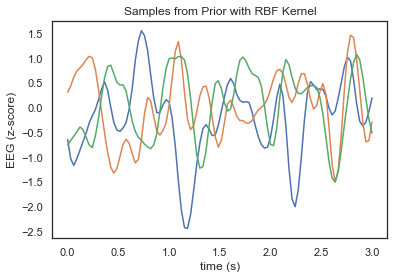

In [7]:
times = torch.linspace(0, 3, 100)
model = EEGGPModel(times, None, likelihood, "rbf", lengthscale_prior=gpytorch.priors.GammaPrior(1.0, 12.0))
# model.eval()
preds = model(times)
for i in range(3):
    plt.plot(times, preds.sample())
plt.title("Samples from Prior with RBF Kernel")
plt.xlabel("time (s)")
plt.ylabel("EEG (z-score)")


Text(0, 0.5, 'EEG (z-score)')

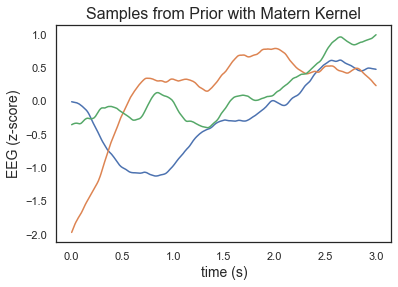

In [70]:
times = torch.linspace(0, 3, 1000)
model = EEGGPModel(times, None, likelihood, "matern",
                 lengthscale_prior=gpytorch.priors.GammaPrior(1.0, 1.0),
                 outputscale_prior=gpytorch.priors.GammaPrior(1.0, 1.0))
# model.eval()
preds = model(times)
for i in range(3):
    plt.plot(times, preds.sample())
plt.title("Samples from Prior with Matern Kernel", size=16)
plt.xlabel("time (s)", size=14)
plt.ylabel("EEG (z-score)", size=14)


In [71]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-4.8547])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(0.5413)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.5413]])),
             ('covar_module.base_kernel.lengthscale_prior.concentration',
              tensor(1.)),
             ('covar_module.base_kernel.lengthscale_prior.rate', tensor(1.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.outputscale_prior.concentration', tensor(1.)),
             ('covar_module.outputscale_prior.rate', te

## Get data sample

In [9]:
from msc.dataset import UniformDataset, SeizuresDataset

u_dataset = UniformDataset()
s_dataset = SeizuresDataset()


loading
done loading


In [10]:
times = u_dataset.get_train_x()
times.shape

torch.Size([1000])

In [11]:
u_sample = u_dataset.get_train_y(1)[0]
u_sample.shape

torch.Size([1000])

In [28]:
s_sample = s_dataset.get_train_y(1, crop_seconds=1000/256, delay_seconds=22)[0]
s_sample.shape

torch.Size([1000])

Text(0, 0.5, 'EEG (z-score)')

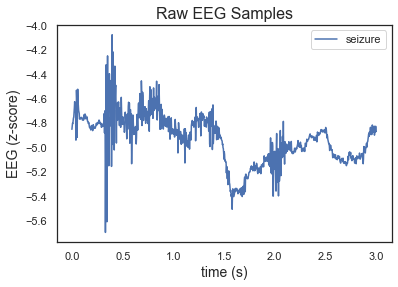

In [50]:
# plt.plot(times, u_sample, label="rest")
plt.plot(times, s_sample, label="seizure")
plt.legend()
plt.title("Raw EEG Samples", size=16)
plt.xlabel("time (s)", size=14)
plt.ylabel("EEG (z-score)", size=14)


## Train model

In [72]:
def training_loop(model, train_x, train_y, num_iters=50, lr=0.1):
    model.set_train_data(train_x)
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_iters):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, num_iters, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

    params = pd.DataFrame(model.named_parameters(), columns=["param_name", "param_value"])
    params['param_value'] = params.param_value.apply(lambda x: x.item())
    return model

model = EEGGPModel(times, None, likelihood, "rbf",
                 lengthscale_prior=gpytorch.priors.GammaPrior(1.0, 1.0),
                 outputscale_prior=gpytorch.priors.GammaPrior(1.0, 1.0))

model = training_loop(model, times, s_sample, num_iters=100)

Iter 1/100 - Loss: -0.333   lengthscale: 1.000   noise: 0.008
Iter 2/100 - Loss: -0.422   lengthscale: 0.938   noise: 0.009
Iter 3/100 - Loss: -0.500   lengthscale: 0.878   noise: 0.010
Iter 4/100 - Loss: -0.552   lengthscale: 0.821   noise: 0.011
Iter 5/100 - Loss: -0.591   lengthscale: 0.767   noise: 0.011
Iter 6/100 - Loss: -0.623   lengthscale: 0.716   noise: 0.013
Iter 7/100 - Loss: -0.641   lengthscale: 0.669   noise: 0.014
Iter 8/100 - Loss: -0.653   lengthscale: 0.626   noise: 0.014
Iter 9/100 - Loss: -0.663   lengthscale: 0.587   noise: 0.015
Iter 10/100 - Loss: -0.654   lengthscale: 0.553   noise: 0.016
Iter 11/100 - Loss: -0.663   lengthscale: 0.521   noise: 0.017
Iter 12/100 - Loss: -0.666   lengthscale: 0.493   noise: 0.017
Iter 13/100 - Loss: -0.677   lengthscale: 0.466   noise: 0.018
Iter 14/100 - Loss: -0.686   lengthscale: 0.438   noise: 0.018
Iter 15/100 - Loss: -0.717   lengthscale: 0.411   noise: 0.018
Iter 16/100 - Loss: -0.738   lengthscale: 0.383   noise: 0.018
I

In [73]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-4.9127])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([-4.9633])),
             ('covar_module.raw_outputscale', tensor(1.1544)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-2.5459]])),
             ('covar_module.base_kernel.lengthscale_prior.concentration',
              tensor(1.)),
             ('covar_module.base_kernel.lengthscale_prior.rate', tensor(1.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.

Text(0, 0.5, 'EEG (z-score)')

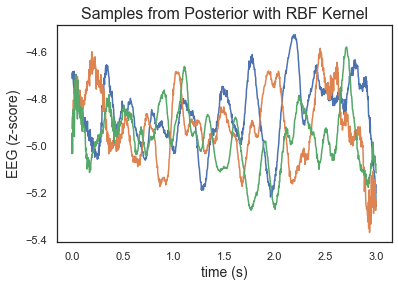

In [69]:
preds = likelihood(model(times))
for i in range(3):
    plt.plot(times, preds.sample())
plt.title("Samples from Posterior with Matern Kernel", size=16)
plt.xlabel("time (s)", size=14)
plt.ylabel("EEG (z-score)", size=14)

In [45]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [46]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [13]:
model.sample_from_prior('prior')

RuntimeError: Unknown prior name 'prior'

## Load GP Maximum Likelihood Estimation Results

In [2]:
# uniform_results_df = pd.read_csv(r"C:\Users\noam\Repositories\noamsgl\msc\results\params\results_uniform_20220112T012831.csv")
uniform_results_df = pd.read_csv(r"C:\Users\noam\Repositories\noamsgl\msc\results\params\results_1000.csv")
uniform_results_df = uniform_results_df.pivot(index='sample_id', columns='param_name', values='param_value')
uniform_results_df

param_name,covar_module.base_kernel.raw_lengthscale,covar_module.raw_outputscale,likelihood.noise_covar.raw_noise
sample_id,,,
0,0.478211,-0.488561,-1.011795
1,0.477431,-0.492144,-1.514724
2,0.478178,-0.490924,-2.017304
3,0.476830,-0.496351,-2.516353
4,0.475036,-0.488972,-3.017599
...,...,...,...
995,-0.444950,0.428572,-6.855521
996,-0.432197,0.407162,-6.504109
997,0.481659,-0.492204,-7.003676


In [3]:
# seizures_results_df = pd.read_csv(r"C:\Users\noam\Repositories\noamsgl\msc\results\params\results_seizures_20220112T032239.csv")
seizures_results_df = pd.read_csv(
    r"C:\Users\noam\Repositories\noamsgl\msc\results\params\results_seizure_20220109T193139.csv")
seizures_results_df = seizures_results_df.pivot(index='sample_id', columns='param_name', values='param_value')
seizures_results_df

param_name,covar_module.base_kernel.raw_lengthscale,covar_module.raw_outputscale,likelihood.noise_covar.raw_noise
sample_id,,,
0,0.467654,0.449511,-0.506070
1,0.477307,0.389437,-1.010462
2,-0.456080,0.450585,-0.571344
3,-0.464846,0.471028,-0.112768
4,0.482202,0.322504,-0.618265
...,...,...,...
1178,0.448448,-0.467655,-10.757590
1179,-0.255313,0.228542,-10.264630
1180,0.469320,-0.489483,-10.744159


In [4]:
# concat
results_df = pd.concat([uniform_results_df, seizures_results_df], keys=('uniform', 'seizures')).rename_axis(
    ['dataset', 'sample_id']).reset_index()

In [5]:
results_df

param_name,dataset,sample_id,covar_module.base_kernel.raw_lengthscale,covar_module.raw_outputscale,likelihood.noise_covar.raw_noise
0,uniform,0,0.478211,-0.488561,-1.011795
1,uniform,1,0.477431,-0.492144,-1.514724
2,uniform,2,0.478178,-0.490924,-2.017304
3,uniform,3,0.476830,-0.496351,-2.516353
4,uniform,4,0.475036,-0.488972,-3.017599
...,...,...,...,...,...
2178,seizures,1178,0.448448,-0.467655,-10.757590
2179,seizures,1179,-0.255313,0.228542,-10.264630
2180,seizures,1180,0.469320,-0.489483,-10.744159
2181,seizures,1181,-0.374430,0.356585,-10.849879


## Plot GP Samples
### Prior
### then Posterior